In [ ]:
from google.colab import drive
drive.mount('/content/drive')

#SE TIVER INDICADOR DE LUCRO FAZER PLOT

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Preparação para simular banco de dados da empresa

# Importe de pacotes

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import psycopg2
from sqlalchemy import create_engine
!pip install psycopg2-binary sqlalchemy

import pandas as pd
from sqlalchemy import create_engine

# Importação de dados

In [ ]:
# Caminhos dos arquivos CSV no Google Drive
path = "/content/drive/MyDrive/northwind/"
file_paths = {
    'categories': f'{path}categories.csv',
    'customers': f'{path}customers.csv',
    'customer_customer_demo': f'{path}customer_customer_demo.csv',
    'customer_demographics': f'{path}customer_demographics.csv',
    'employees': f'{path}employees.csv',
    'employee_territories': f'{path}employee_territories.csv',
    'orders': f'{path}orders.csv',
    'order_details': f'{path}order_details.csv',
    'products': f'{path}products.csv',
    'region': f'{path}region.csv',
    'shippers': f'{path}shippers.csv',
    'suppliers': f'{path}suppliers.csv',
    'territories': f'{path}territories.csv',
    'us_states': f'{path}us_states.csv'
}

# Função para carregar e processar os CSVs
def load_and_process_csv(path, delimiter=';'):
    try:
        df = pd.read_csv(path, delimiter=delimiter, on_bad_lines='skip')
        return df
    except Exception as e:
        print(f"Erro ao ler o arquivo {path}: {e}")
        return None

# Carregar os arquivos CSV em dataframes
dataframes = {name: load_and_process_csv(path) for name, path in file_paths.items()}



In [ ]:
# Verificar os dados carregados
for name, df in dataframes.items():
    print(f"{name}:\n{df.head()}\n")

categories:
   category_id   category_name  \
0            1       Beverages   
1            2      Condiments   
2            3     Confections   
3            4  Dairy Products   
4            5  Grains/Cereals   

                                         description picture  
0        Soft drinks, coffees, teas, beers, and ales      \x  
1  Sweet and savory sauces, relishes, spreads, an...      \x  
2                Desserts, candies, and sweet breads      \x  
3                                            Cheeses      \x  
4                Breads, crackers, pasta, and cereal      \x  

customers:
  customer_id                        company_name        contact_name  \
0       ALFKI                 Alfreds Futterkiste        Maria Anders   
1       ANATR  Ana Trujillo Emparedados y helados        Ana Trujillo   
2       ANTON             Antonio Moreno Taquería      Antonio Moreno   
3       AROUT                     Around the Horn        Thomas Hardy   
4       BERGS               

Limpeza básica dos dados

In [ ]:

for name, df in dataframes.items():
    df.drop_duplicates(inplace=True)
    df.dropna(how='all', inplace=True)

# Gerando indicadores de performace

In [ ]:
# Unir orders e order_details
orders = dataframes['orders']
order_details = dataframes['order_details']
products = dataframes['products']

# 1. Unir orders e order_details
merged_df = pd.merge(orders, order_details, on='order_id')


# 2. Unir com products para obter detalhes dos produtos
# A coluna `unit_price` foi renomeada para `unit_price_product` após o merge
merged_df = pd.merge(merged_df, products, on='product_id', suffixes=('_order', '_product'))

# 3. Calcular a receita total
merged_df['Total'] = merged_df['unit_price_product'] * merged_df['quantity']
receita_total = merged_df['Total'].sum()

# 4. Calcular o número de pedidos
numero_pedidos = orders['order_id'].nunique()

# 5. Calcular o ticket médio por pedido
ticket_medio = receita_total / numero_pedidos

# 6. Identificar os produtos mais vendidos
produtos_mais_vendidos = merged_df.groupby('product_name')['quantity'].sum().sort_values(ascending=False).head(10)

# 7. Identificar os clientes mais valiosos
clientes_mais_valiosos = merged_df.groupby('customer_id')['Total'].sum().sort_values(ascending=False).head(10)

# 8. Identificar os produtos menos vendidos
produtos_menos_vendidos = merged_df.groupby('product_name')['quantity'].sum().sort_values(ascending=True).head(10)



In [ ]:

# Criar um DataFrame com as informações
data = {
    'Métrica': ['Receita Total', 'Número de Pedidos', 'Ticket Médio por Pedido'],
    'Valor': [f'R${receita_total:.2f}', numero_pedidos, f'R${ticket_medio:.2f}']
}
df_informacoes = pd.DataFrame(data)

# Criar um DataFrame para os produtos mais vendidos
df_produtos_mais_vendidos = pd.DataFrame(produtos_mais_vendidos.items(), columns=['Produto', 'Quantidade Vendida'])

# Criar um DataFrame para os produtos mais vendidos
df_produtos_menos_vendidos = pd.DataFrame(produtos_menos_vendidos.items(), columns=['Produto', 'Quantidade Vendida'])

# Criar um DataFrame para os clientes mais valiosos
df_clientes_mais_valiosos = pd.DataFrame(clientes_mais_valiosos.items(), columns=['Cliente', 'Valor Gasto'])

# Analises relativas aos produtos fornecidos pela empresa

Produtos mais vendidos

<ipython-input-11-5bbc0c8e2636>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=produtos_mais_vendidos.values, y=produtos_mais_vendidos.index, palette="viridis")


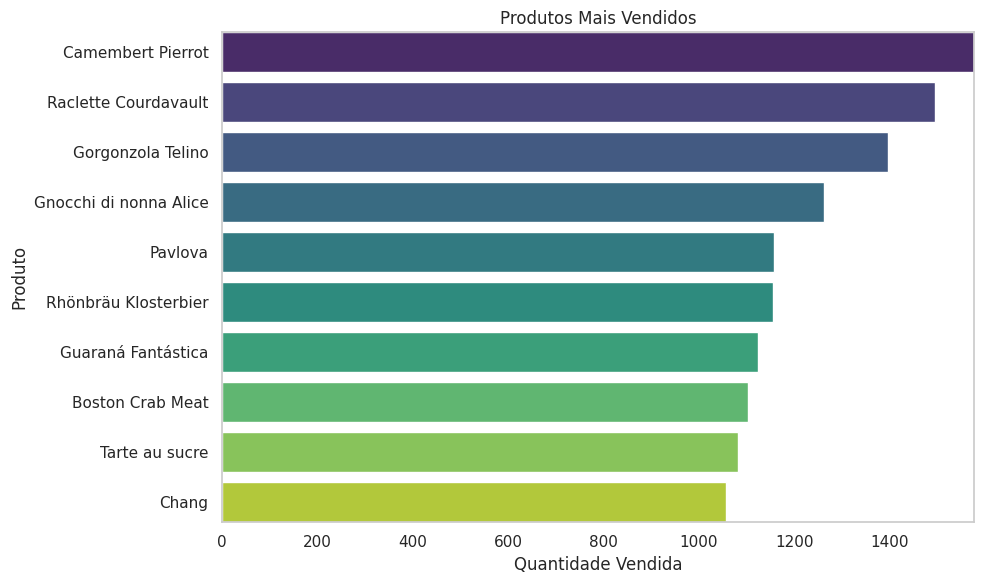

In [ ]:

# Criar visualizações
sns.set(style="whitegrid")

# Produtos mais vendidos
plt.figure(figsize=(10, 6))
sns.barplot(x=produtos_mais_vendidos.values, y=produtos_mais_vendidos.index, palette="viridis")
plt.title("Produtos Mais Vendidos")
plt.xlabel("Quantidade Vendida")
plt.ylabel("Produto")
plt.tight_layout()
plt.autoscale(axis='x', tight=True)
plt.autoscale(axis='y', tight=True)
plt.grid(False)
plt.show()


Produtos com maior taxa de crescimento

<ipython-input-12-b48af3d9a40c>:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='growth_rate', y='product_name', data=top_growth_products, palette='viridis')


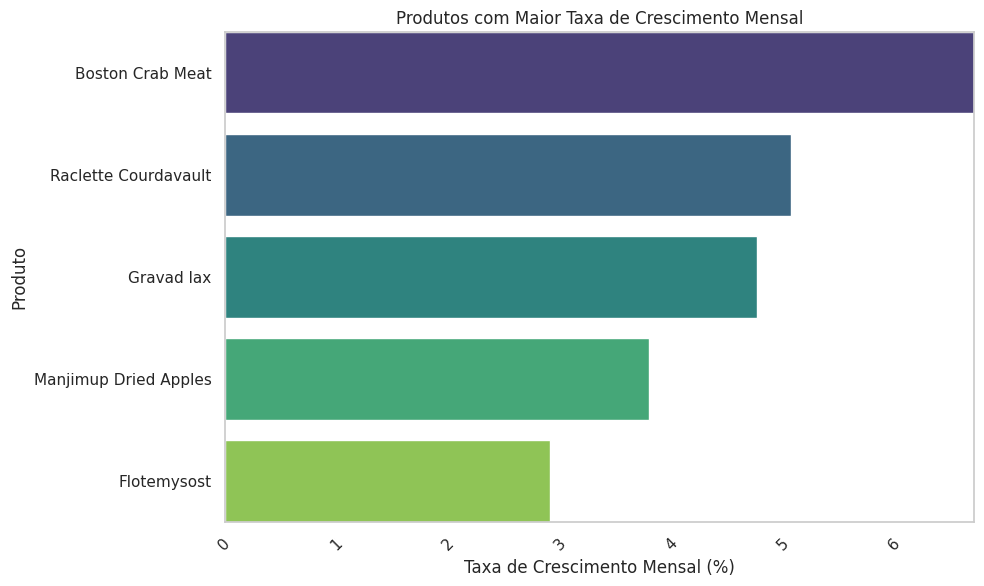

In [ ]:
import numpy as np
# Verifique se 'order_date' está no formato datetime
merged_df['order_date'] = pd.to_datetime(merged_df['order_date'])

# Extrair ano e mês da data do pedido
merged_df['year_month'] = merged_df['order_date'].dt.to_period('M')

# Agrupar por ano e mês e somar as quantidades vendidas
sales_over_time = merged_df.groupby(['product_id', 'year_month'])['quantity'].sum().reset_index()

# Calcular a taxa de crescimento mensal
sales_over_time['growth_rate'] = sales_over_time.groupby('product_id')['quantity'].pct_change()
sales_over_time['growth_rate'] = sales_over_time['growth_rate'].replace([np.inf, -np.inf], np.nan).fillna(0)

# Calcular a média da taxa de crescimento mensal para cada produto
top_growth_products = sales_over_time.groupby('product_id')['growth_rate'].mean().nlargest(5).reset_index()

# Mesclar com os detalhes do produto para obter o nome do produto
top_growth_products = pd.merge(top_growth_products, products[['product_id', 'product_name']], on='product_id')

# Criar o gráfico de barras horizontais
plt.figure(figsize=(10, 6))
sns.barplot(x='growth_rate', y='product_name', data=top_growth_products, palette='viridis')
plt.title('Produtos com Maior Taxa de Crescimento Mensal')
plt.xlabel('Taxa de Crescimento Mensal (%)')
plt.ylabel('Produto')
plt.grid(False)
plt.tight_layout()
plt.autoscale(axis='x', tight=True)
plt.autoscale(axis='y', tight=True)
plt.xticks(rotation=45)
plt.show()

Produtos para investimento

<ipython-input-13-4121e1c55682>:55: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='investment_score', y='product_name', data=top_investment_products, palette='viridis')


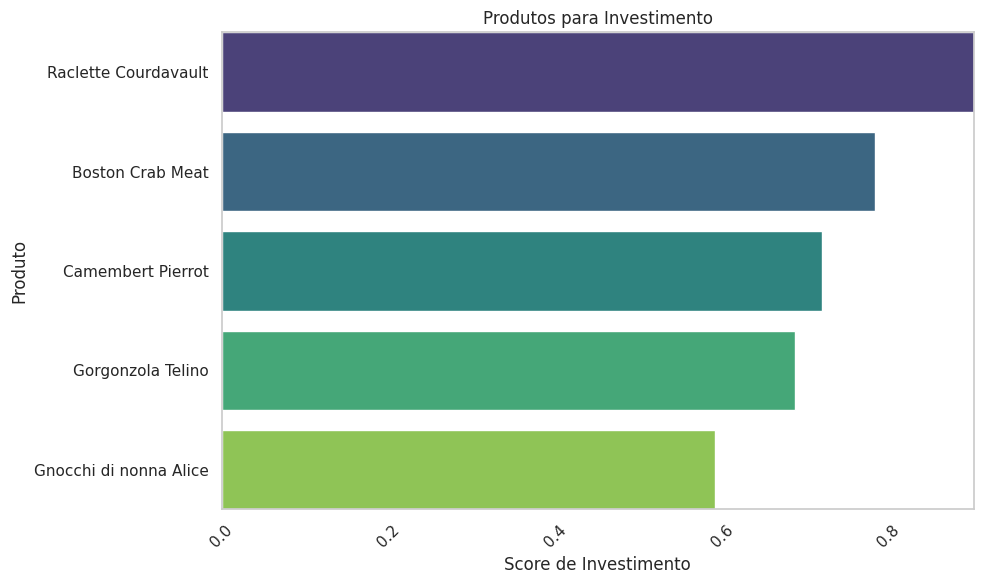

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Verifique se 'order_date' está no formato datetime
merged_df['order_date'] = pd.to_datetime(merged_df['order_date'])

# Extrair ano e mês da data do pedido
merged_df['year_month'] = merged_df['order_date'].dt.to_period('M')

# Agrupar por produto e calcular vendas totais e taxa de crescimento mensal
sales_over_time = merged_df.groupby(['product_id', 'year_month'])['quantity'].sum().reset_index()

# Calcular a taxa de crescimento mensal
sales_over_time['growth_rate'] = sales_over_time.groupby('product_id')['quantity'].pct_change()
sales_over_time['growth_rate'] = sales_over_time['growth_rate'].replace([np.inf, -np.inf], np.nan).fillna(0)

# Calcular vendas totais e média da taxa de crescimento mensal para cada produto
product_metrics = sales_over_time.groupby('product_id').agg({
    'quantity': 'sum',
    'growth_rate': 'mean'
}).reset_index()

# Identificar os 10 clientes mais valiosos
clientes_mais_valiosos = merged_df.groupby('customer_id')['Total'].sum().sort_values(ascending=False).head(10).index

# Filtrar as vendas desses clientes
vendas_clientes_valiosos = merged_df[merged_df['customer_id'].isin(clientes_mais_valiosos)]

# Calcular a quantidade total comprada pelos melhores clientes para cada produto
vendas_por_melhores_clientes = vendas_clientes_valiosos.groupby('product_id')['quantity'].sum().reset_index()
vendas_por_melhores_clientes = vendas_por_melhores_clientes.rename(columns={'quantity': 'best_customers_quantity'})

# Mesclar com product_metrics
product_metrics = pd.merge(product_metrics, vendas_por_melhores_clientes, on='product_id', how='left')
product_metrics['best_customers_quantity'] = product_metrics['best_customers_quantity'].fillna(0)

# Normalizar os valores
product_metrics['normalized_quantity'] = (product_metrics['quantity'] - product_metrics['quantity'].min()) / (product_metrics['quantity'].max() - product_metrics['quantity'].min())
product_metrics['normalized_growth_rate'] = (product_metrics['growth_rate'] - product_metrics['growth_rate'].min()) / (product_metrics['growth_rate'].max() - product_metrics['growth_rate'].min())
product_metrics['normalized_best_customers_quantity'] = (product_metrics['best_customers_quantity'] - product_metrics['best_customers_quantity'].min()) / (product_metrics['best_customers_quantity'].max() - product_metrics['best_customers_quantity'].min())

# Calcular o score de investimento (média das métricas normalizadas)
product_metrics['investment_score'] = (product_metrics['normalized_quantity'] + product_metrics['normalized_growth_rate'] + product_metrics['normalized_best_customers_quantity']) / 3

# Mesclar com os detalhes do produto para obter o nome do produto
product_metrics = pd.merge(product_metrics, products[['product_id', 'product_name']], on='product_id')

# Selecionar os produtos com os maiores scores de investimento
top_investment_products = product_metrics.sort_values(by='investment_score', ascending=False).head(5)

# Criar o gráfico de barras horizontais
plt.figure(figsize=(10, 6))
sns.barplot(x='investment_score', y='product_name', data=top_investment_products, palette='viridis')
plt.title('Produtos para Investimento')
plt.xlabel('Score de Investimento')
plt.ylabel('Produto')
plt.xticks(rotation=45)
plt.grid(False)
plt.tight_layout()
plt.autoscale(axis='x', tight=True)
plt.autoscale(axis='y', tight=True)
plt.show()


In [ ]:
# Renomear a coluna 'product_name' no DataFrame 'products' para evitar conflitos
products_renamed = products.rename(columns={'product_name': 'product_name_detail'})

# Mesclar com os detalhes do produto para obter o nome do produto
product_metrics = pd.merge(product_metrics, products_renamed[['product_id', 'product_name_detail']], on='product_id')

# Selecionar os produtos com os maiores scores de investimento
top_investment_products = product_metrics.sort_values(by='investment_score', ascending=False).head(5)

# Selecionar apenas as colunas 'product_name_detail' e 'investment_score' para impressão
top_investment = top_investment_products[['product_name_detail', 'investment_score']]

Receita total por categoria de produto

<ipython-input-15-19df30bc5423>:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Total', y='category_name', data=receita_por_categoria, palette='viridis')


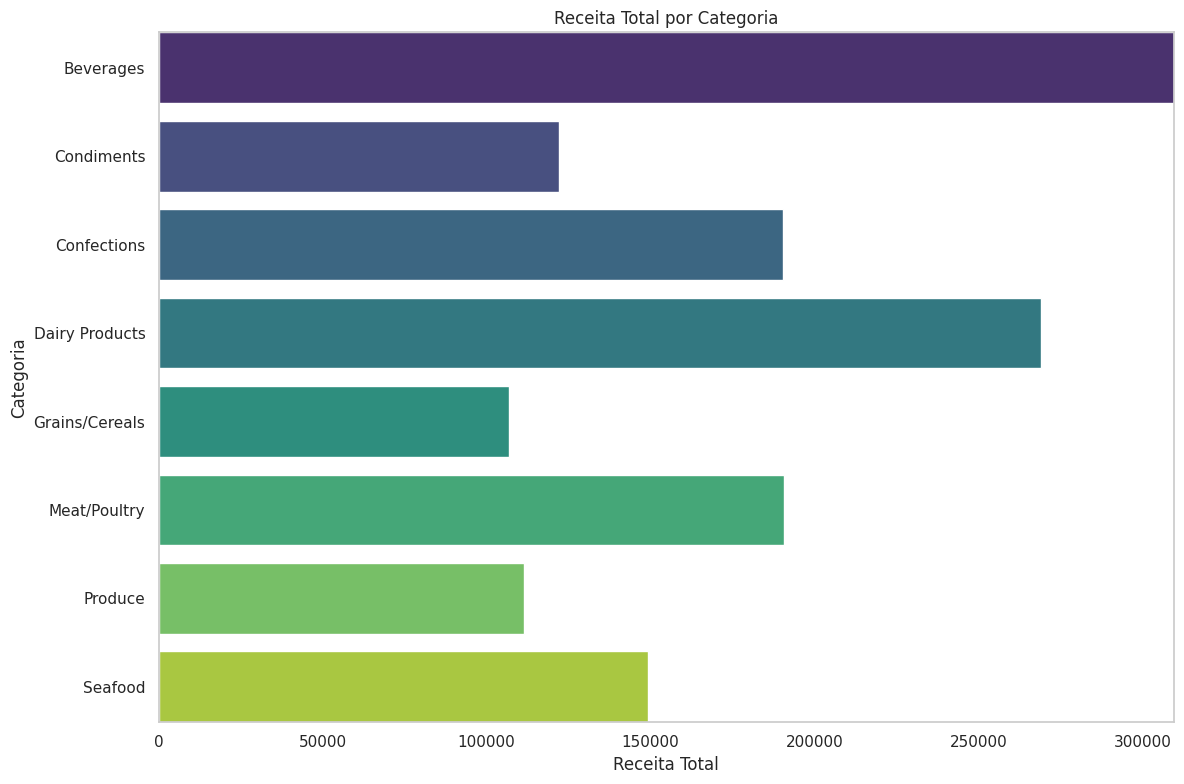

In [ ]:

categories = dataframes['categories']
# 3. Unir com categories para obter detalhes das categorias

# 3. Unir com categories para obter detalhes das categorias
merged_df = pd.merge(merged_df, categories, on='category_id', suffixes=('_product', '_category'))

# 4. Calcular a receita total
merged_df['Total'] = merged_df['unit_price_product'] * merged_df['quantity']
receita_total = merged_df['Total'].sum()

# 5. Calcular o número de pedidos
numero_pedidos = orders['order_id'].nunique()

# 6. Calcular o ticket médio por pedido
ticket_medio = receita_total / numero_pedidos

# 7. Identificar os produtos mais vendidos
produtos_mais_vendidos = merged_df.groupby('product_name')['quantity'].sum().sort_values(ascending=False).head(10)

# 8. Identificar os clientes mais valiosos
clientes_mais_valiosos = merged_df.groupby('customer_id')['Total'].sum().sort_values(ascending=False).head(10)

# 9. Identificar os produtos menos vendidos
produtos_menos_vendidos = merged_df.groupby('product_name')['quantity'].sum().sort_values(ascending=True).head(10)

# 10. Calcular a receita total por categoria
receita_por_categoria = merged_df.groupby('category_name')['Total'].sum().reset_index()

# 11. Criar o gráfico de barras para mostrar as vendas por categoria
plt.figure(figsize=(12, 8))
sns.barplot(x='Total', y='category_name', data=receita_por_categoria, palette='viridis')
plt.title('Receita Total por Categoria')
plt.xlabel('Receita Total')
plt.ylabel('Categoria')
plt.grid(False)
plt.tight_layout()
plt.autoscale(axis='x', tight=True)
plt.autoscale(axis='y', tight=True)
plt.show()

# Analise relativa aos clientes

Principais clientes

<ipython-input-16-5f84dc328f1a>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=clientes_mais_valiosos.values, y=clientes_mais_valiosos.index, palette="viridis")


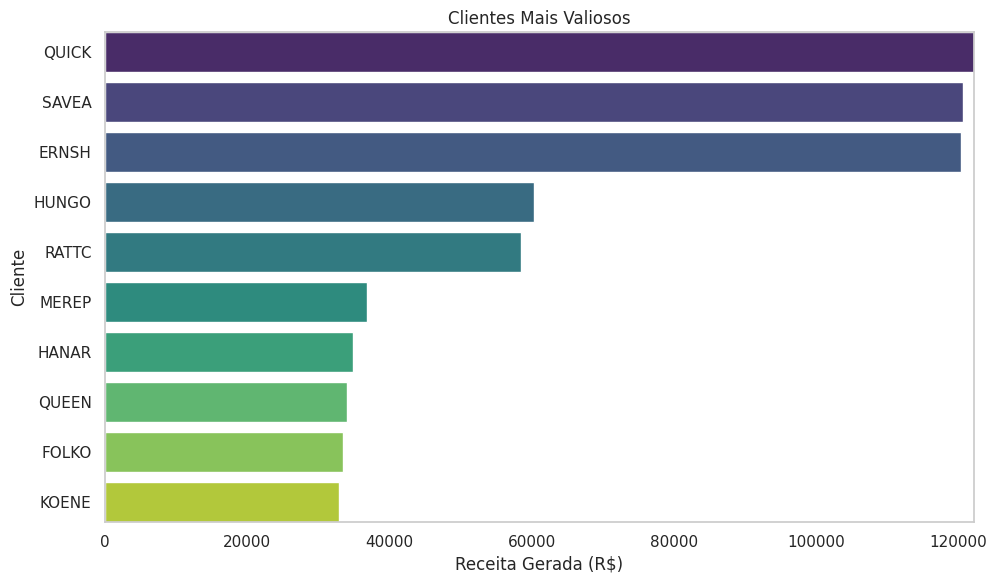

In [ ]:

plt.figure(figsize=(10, 6))
sns.barplot(x=clientes_mais_valiosos.values, y=clientes_mais_valiosos.index, palette="viridis")
plt.title("Clientes Mais Valiosos")
plt.xlabel("Receita Gerada (R$)")
plt.ylabel("Cliente")
plt.grid(False)
plt.tight_layout()
plt.autoscale(axis='x', tight=True)
plt.autoscale(axis='y', tight=True)
plt.show()

In [ ]:
!pip install upsetplot

  Using cached UpSetPlot-0.9.0.tar.gz (23 kB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for upsetplot: filename=UpSetPlot-0.9.0-py3-none-any.whl size=24817 sha256=41a0e55e342392a64fad5e6212f6bfda425a76d5671cb2c0cf27a4602315bdca
  Stored in directory: /root/.cache/pip/wheels/73/42/9f/1c9718ea27f30466d2787e0f7d88a7cb11942e3460c17e0ef6
Successfully built upsetplot


<Figure size 1200x800 with 0 Axes>

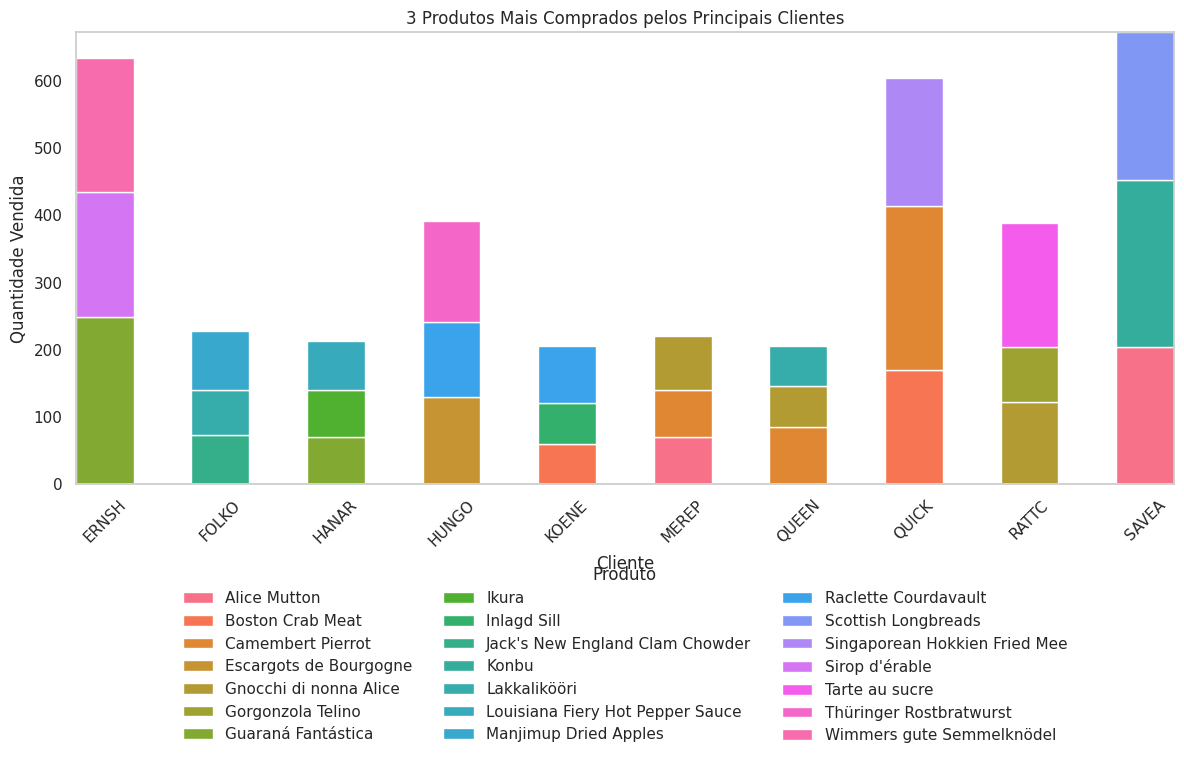

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Identificar os 10 clientes mais valiosos
clientes_mais_valiosos = merged_df.groupby('customer_id')['Total'].sum().sort_values(ascending=False).head(10).index

# Filtrar as vendas desses clientes
vendas_clientes_valiosos = merged_df[merged_df['customer_id'].isin(clientes_mais_valiosos)]

# Identificar os 3 produtos mais comprados por cada cliente
top_products_by_customer = vendas_clientes_valiosos.groupby(['customer_id', 'product_name'])['quantity'].sum().reset_index()

# Filtrar para manter apenas os top 3 produtos por cliente
top_products_by_customer['rank'] = top_products_by_customer.groupby('customer_id')['quantity'].rank(method='first', ascending=False)
top_products_by_customer = top_products_by_customer[top_products_by_customer['rank'] <= 3]

# Preparar os dados para o gráfico de barras agrupadas
top_products_by_customer = top_products_by_customer.sort_values(['customer_id', 'rank'])
pivot_df = top_products_by_customer.pivot(index='customer_id', columns='product_name', values='quantity').fillna(0)

# Criar o gráfico de barras agrupadas
plt.figure(figsize=(12, 8))
colors = sns.color_palette("husl", len(pivot_df.columns))
pivot_df.plot(kind='bar', stacked=True, figsize=(12, 8), color=colors)
plt.grid(False)
plt.title('3 Produtos Mais Comprados pelos Principais Clientes')
plt.xlabel('Cliente')
plt.ylabel('Quantidade Vendida')
plt.legend(title='Produto', bbox_to_anchor=(0.5, -0.15), loc='upper center', ncol=3, frameon=False)
plt.xticks(rotation=45)
plt.tight_layout()
plt.autoscale(axis='x', tight=True)
plt.autoscale(axis='y', tight=True)
plt.show()


# Analise relativa aos fornecedores

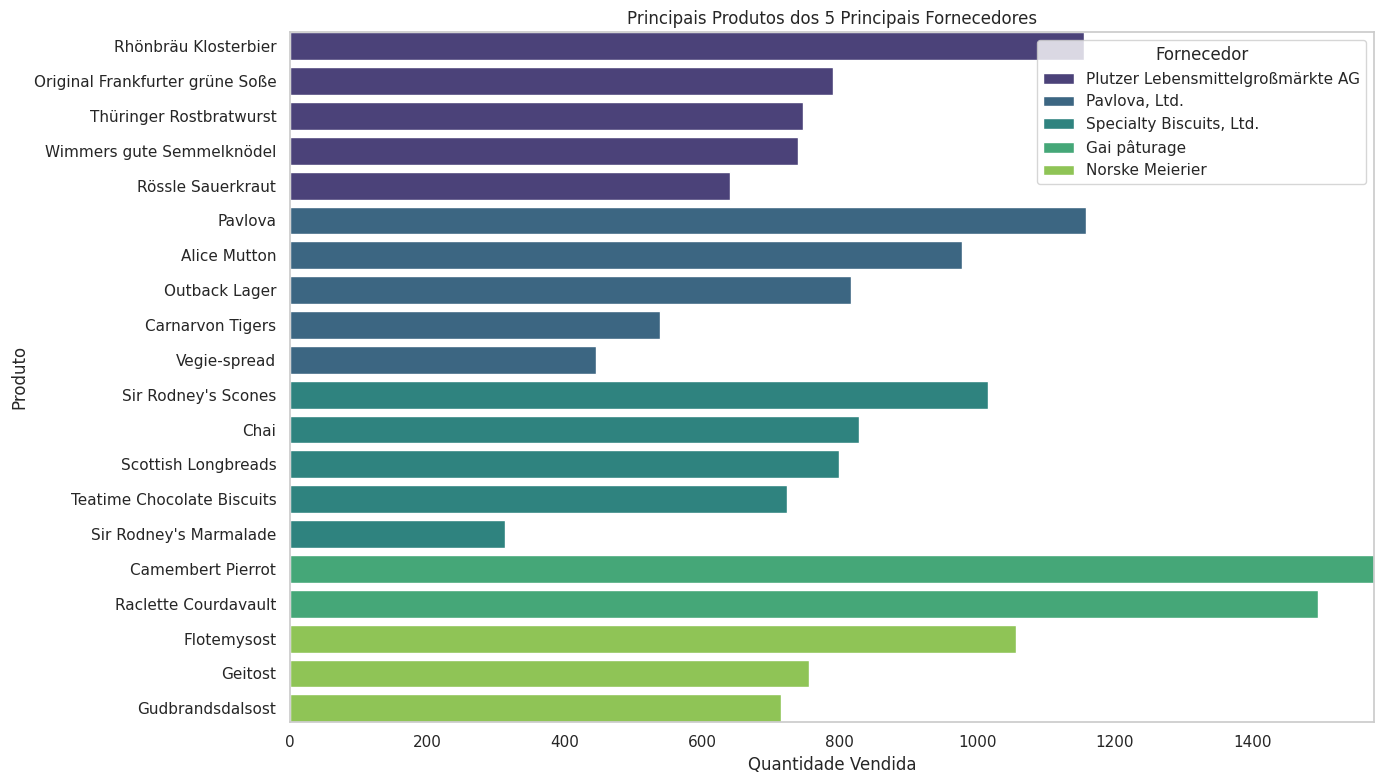

In [ ]:

suppliers = dataframes['suppliers']
# Calcular a quantidade total vendida por fornecedor
sales_by_supplier = merged_df.groupby('supplier_id')['quantity'].sum().reset_index()

# Obter os 5 principais fornecedores
top_suppliers = sales_by_supplier.nlargest(5, 'quantity')

# Mesclar para obter os nomes dos fornecedores
top_suppliers = top_suppliers.merge(suppliers[['supplier_id', 'company_name']], on='supplier_id')

# Inicializar um DataFrame para armazenar os principais produtos de cada fornecedor
top_supplier_products = pd.DataFrame()

# Para cada fornecedor, obter os principais produtos
for supplier_id in top_suppliers['supplier_id']:
    supplier_products = merged_df[merged_df['supplier_id'] == supplier_id]
    top_products = supplier_products.groupby('product_name')['quantity'].sum().reset_index().nlargest(5, 'quantity')
    top_products['supplier_id'] = supplier_id
    top_supplier_products = pd.concat([top_supplier_products, top_products])

# Mesclar para obter os nomes dos fornecedores no DataFrame de produtos
top_supplier_products = top_supplier_products.merge(suppliers[['supplier_id', 'company_name']], on='supplier_id')

# Criar o gráfico
plt.figure(figsize=(14, 8))
sns.barplot(x='quantity', y='product_name', hue='company_name', data=top_supplier_products, palette='viridis')
plt.title('Principais Produtos dos 5 Principais Fornecedores')
plt.xlabel('Quantidade Vendida')
plt.ylabel('Produto')
plt.legend(title='Fornecedor', loc='upper right')
plt.grid(False)
plt.tight_layout()
plt.autoscale(axis='x', tight=True)
plt.autoscale(axis='y', tight=True)
plt.show()

# Analise relativa as regiões em atividade

Vendas por região

<ipython-input-20-f53891f23d23>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='ship_region', y='quantity', data=region_sales_qty, palette='coolwarm')


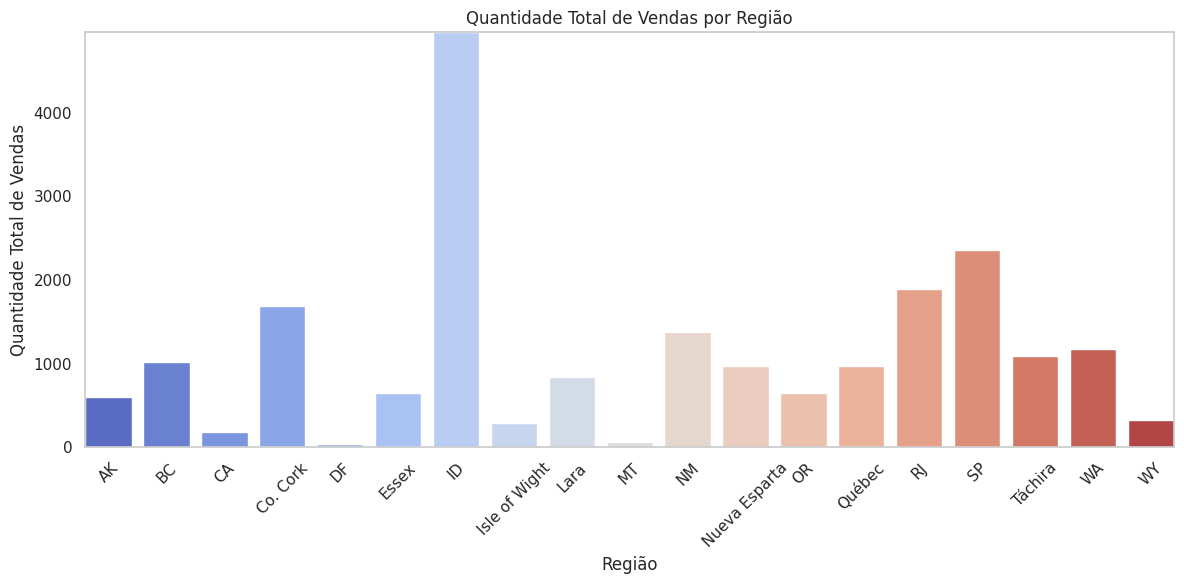

In [ ]:

# Agrupar os dados por região e somar as quantidades vendidas
region_sales_qty = merged_df.groupby('ship_region')['quantity'].sum().reset_index()

# Criar o gráfico de barras
plt.figure(figsize=(12, 6))
sns.barplot(x='ship_region', y='quantity', data=region_sales_qty, palette='coolwarm')
plt.title('Quantidade Total de Vendas por Região')
plt.xlabel('Região')
plt.ylabel('Quantidade Total de Vendas')
plt.xticks(rotation=45)
plt.grid(False)
plt.tight_layout()
plt.autoscale(axis='x', tight=True)
plt.autoscale(axis='y', tight=True)
plt.show()

Receita total por região

<ipython-input-21-7255b63367c6>:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Total', y='region', data=receita_por_regiao, palette='viridis')


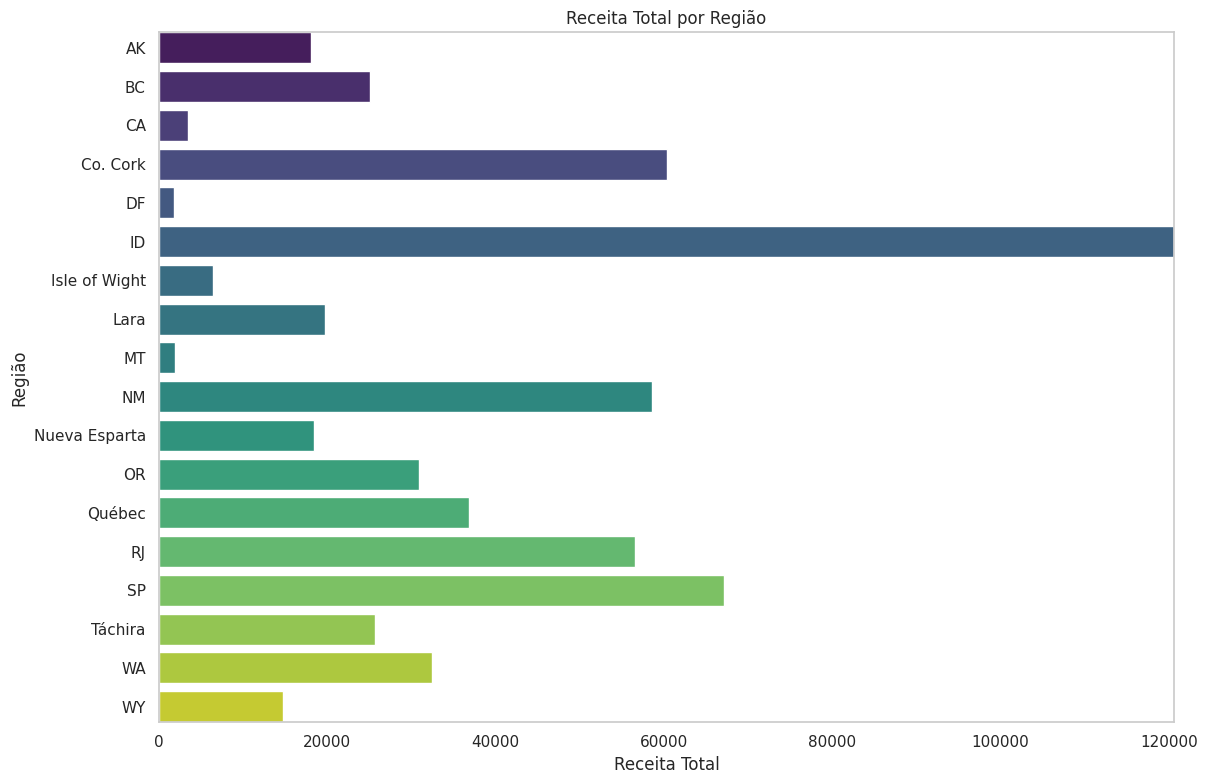

In [ ]:
customers = dataframes['customers']
# 4. Unir com customers para obter detalhes dos clientes e suas regiões
merged_df = pd.merge(merged_df, customers[['customer_id', 'region']], on='customer_id', how='left')

# 5. Calcular a receita total
merged_df['Total'] = merged_df['unit_price_product'] * merged_df['quantity']
receita_total = merged_df['Total'].sum()

# 6. Calcular o número de pedidos
numero_pedidos = orders['order_id'].nunique()

# 7. Calcular o ticket médio por pedido
ticket_medio = receita_total / numero_pedidos

# 8. Identificar os produtos mais vendidos
produtos_mais_vendidos = merged_df.groupby('product_name')['quantity'].sum().sort_values(ascending=False).head(10)

# 9. Identificar os clientes mais valiosos
clientes_mais_valiosos = merged_df.groupby('customer_id')['Total'].sum().sort_values(ascending=False).head(10)

# 10. Identificar os produtos menos vendidos
produtos_menos_vendidos = merged_df.groupby('product_name')['quantity'].sum().sort_values(ascending=True).head(10)

# 11. Calcular a receita total por região
receita_por_regiao = merged_df.groupby('region')['Total'].sum().reset_index()

# 12. Criar o gráfico de barras para mostrar as vendas por região
plt.figure(figsize=(12, 8))
sns.barplot(x='Total', y='region', data=receita_por_regiao, palette='viridis')
plt.title('Receita Total por Região')
plt.xlabel('Receita Total')
plt.ylabel('Região')
plt.grid(False)
plt.tight_layout()
plt.autoscale(axis='x', tight=True)
plt.autoscale(axis='y', tight=True)
plt.show()


# Conclusões

In [ ]:
# Imprimir as tabelas

print("\nProdutos Mais Vendidos:\n")
print(df_produtos_mais_vendidos)
print("\nProdutos Menos Vendidos:\n")
print("Produtos com baixas vendas podem ser descontinuados ou diminuir o estoque")
print(df_produtos_menos_vendidos)
print("\nProdutos com grande potencial de investimento:\n")
print("Investir em marketing e estoque para esses produtos pode potencialmente aumentar a receita.")
print(top_investment)
print("\nProdutos com maior taxa de crescimento:\n")
print(top_growth_products)

print("\nClientes Mais Valiosos:\n")
print(" Oferecer incentivos, descontos exclusivos e um atendimento personalizado a esses clientes pode aumentar a retenção")
print(df_clientes_mais_valiosos)
print("\nProdutos mais comprados por clientes:\n")
print("Isso ajuda a ter uma noção de quais produtos se deve aumentar o estoque e possivelmente regular o preçio de venda")
print(top_products_by_customer)


print("\nPrincipais fornecedores e seus produtos:\n")
print("Negociar melhores termos pode ajudar a garantir a continuidade do fornecimento e potencialmente reduzir custos")
print(top_supplier_products)

print("\nReceita de cada categoria:\n")
print("Isso pode orientar decisões sobre quais categorias expandir ou promover")
print(receita_por_categoria)
print("\nReceita total por região:\n")
print("Pode revelar áreas com maior potencial de crescimento ou regiões que precisam de mais esforços de marketing")
print(region_sales)


Produtos Mais Vendidos:

                  Produto  Quantidade Vendida
0       Camembert Pierrot                1577
1    Raclette Courdavault                1496
2       Gorgonzola Telino                1397
3  Gnocchi di nonna Alice                1263
4                 Pavlova                1158
5    Rhönbräu Klosterbier                1155
6      Guaraná Fantástica                1125
7        Boston Crab Meat                1103
8          Tarte au sucre                1083
9                   Chang                1057

Produtos Menos Vendidos:

Produtos com baixas vendas podem ser descontinuados ou diminuir o estoque
                     Produto  Quantidade Vendida
0            Mishi Kobe Niku                  95
1               Genen Shouyu                 122
2                 Gravad lax                 125
3                  Chocolade                 138
4  Laughing Lumberjack Lager                 184
5           Valkoinen suklaa                 235
6  Louisiana Hot Spiced 

NameError: name 'region_sales' is not defined

**Conclusões Finais e Recomendações:**

1.  Foco em Produtos Populares:
* Investimento: Concentre investimentos em produtos com alta taxa de crescimento e popularidade entre os melhores clientes. Os top 5 produtos identificados devem receber prioridade em campanhas de marketing e reabastecimento de estoque
* Promoções: Crie promoções específicas para os produtos mais vendidos para maximizar as vendas.

2.  Gestão de Clientes Valiosos:
* Fidelização: Desenvolva programas de fidelidade para os principais clientes. Ofereça descontos exclusivos, promoções personalizadas e um atendimento ao cliente superior para mantê-los engajados.
* Feedback: Solicite feedback regularmente desses clientes para entender melhor suas necessidades e melhorar continuamente os produtos e serviços.
**negrito**

3.  Ajuste de Portfólio de Produtos:
* Descontinuação: Considere descontinuar ou diminuir o estoque produtos menos vendidos. Avalie se esses produtos têm potencial para se tornarem mais populares com ajustes ou se apesar das baixas vendas esta crescendo.
* Diversificação: Explore oportunidades de diversificação de produtos dentro das categorias mais vendidas para aumentar a oferta e atrair mais clientes.

4.  Estratégia de Fornecimento:
* Negociações: Negocie melhores termos com os principais fornecedores, especialmente para produtos estratégicos. Garantir preços competitivos e fornecimento constante pode aumentar a margem de lucro.
* Relações: Mantenha boas relações com os fornecedores para garantir qualidade e continuidade no fornecimento de produtos.

5.  Expansão Geográfica:
*  Marketing Regional: Direcione esforços de marketing para regiões com maior potencial de crescimento.